In [6]:
%load_ext autoreload
import random
from openff.toolkit.topology import Molecule
import h5py
import numpy as onp
import jax
import jax.numpy as jnp
import jax_md
import espalomax as esp
from concurrent import futures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# from jax import numpy as jnp
# from openff.toolkit.topology import Molecule
# from openff.toolkit.typing.engines.smirnoff import ForceField
# smiles = "CC"
# molecule = Molecule.from_smiles(smiles)
# molecule.assign_partial_charges("zeros")
# forcefield = ForceField("openff_unconstrained-2.0.0.offxml")
# system = forcefield.create_openmm_system(
#     molecule.to_topology(),
#     charge_from_molecules=[molecule],
# )

# from jax_md.mm_utils import parameters_from_openmm_system
# parameters = parameters_from_openmm_system(system)
# molecule.generate_conformers()
# coordinate = molecule.conformers[0]._value * 0.1
# coordinate = jnp.array(coordinate)

# from jax_md import space
# displacement_fn, shift_fn = space.free()

# from jax_md.mm import mm_energy_fn
# energy_fn, _ = mm_energy_fn(
#     displacement_fn, default_mm_parameters=parameters,
# )

# u = energy_fn(coordinate)

In [8]:
# from jax_md import simulate
# temperature = 1.0
# dt = 1e-3
# init, update = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, temperature)
# state = init(jax.random.PRNGKey(2666), coordinate)
# update = jax.jit(update)

In [9]:
# traj = []
# for _ in range(1000):
#     state = update(state)
#     traj.append(state.position)
# traj = jnp.stack(traj)

In [10]:
smiles = "N#N"
molecule = Molecule.from_smiles(smiles)
traj = onp.zeros((100, 2, 3))
traj[:, -1, 0] = onp.random.uniform(3.0, 7.0, size=(len(traj), ))
traj = jnp.array(traj)

In [11]:
u = 2.0 * (traj[:, -1, 0] - 5.0) ** 2

In [12]:
# from openmm import unit
# for _traj in traj:
#     molecule.add_conformer(_traj * unit.nanometer)

In [13]:
model = esp.nn.Parametrization(
    representation=esp.nn.GraphAttentionNetwork(128, 3),
    janossy_pooling=esp.nn.JanossyPooling(128, 4),
)

In [14]:
g = esp.Graph.from_openff_molecule(molecule)

/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:66: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()
/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:81: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()


In [15]:
def get_loss(nn_params, g, x, u):
    ff_params = model.apply(nn_params, g)
    u_hat = esp.mm.get_energy(ff_params, x, terms=["bond"])
    u_hat = u_hat - u_hat.mean()
    u = u - u.mean()
    return ((u - u_hat) ** 2).mean()

# @jax.jit
def step(state, g, x, u):
    nn_params = state.params
    grads = jax.grad(get_loss)(nn_params, g, x, u)
    state = state.apply_gradients(grads=grads)
    return state

import optax
optimizer = optax.chain(
    optax.additive_weight_decay(1e-5),
    optax.adam(learning_rate=1e-5),
)

nn_params = model.init(jax.random.PRNGKey(2667), g)
from flax.training.train_state import TrainState
from flax.training.checkpoints import save_checkpoint
state = TrainState.create(
     apply_fn=model.apply, params=nn_params, tx=optimizer,
)

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


In [16]:
import tqdm
import random
ks = []
for idx_batch in range(10000):
        # key = (g.n_atoms, g.n_bonds, g.n_angles, g.n_propers, g.n_impropers, x.shape[0])
        # state = compiled[key](state, g, x, u)
        state = step(state, g, traj, u)
        ff_params = model.apply(state.params, g)
        ks.append(ff_params["bond"]["coefficients"][0, 0].item())
        u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


KeyboardInterrupt: 

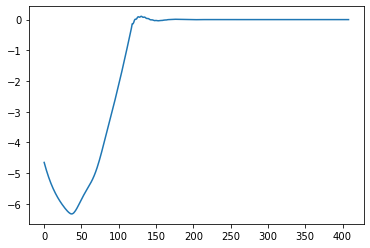

In [17]:
from matplotlib import pyplot as plt
plt.plot(ks)

In [18]:
from sklearn.metrics import r2_score
r2_score(u - u.mean(), u_hat - u_hat.mean())

0.9999999999974855

In [19]:
jnp.abs((u - u.mean()) - (u_hat - u_hat.mean()))

DeviceArray([4.76837158e-07, 3.81469727e-06, 1.90734863e-06,
             1.43051147e-06, 2.38418579e-07, 8.58306885e-06,
             7.62939453e-06, 4.76837158e-06, 2.86102295e-06,
             4.76837158e-07, 4.52995300e-06, 9.53674316e-07,
             0.00000000e+00, 3.81469727e-06, 3.57627869e-06,
             4.76837158e-07, 4.29153442e-06, 3.33786011e-06,
             1.90734863e-06, 3.33786011e-06, 8.10623169e-06,
             9.53674316e-07, 6.19888306e-06, 2.38418579e-06,
             4.76837158e-07, 4.76837158e-06, 4.76837158e-07,
             3.33786011e-06, 3.81469727e-06, 1.90734863e-06,
             6.67572021e-06, 1.90734863e-06, 4.29153442e-06,
             4.29153442e-06, 0.00000000e+00, 1.43051147e-06,
             3.57627869e-06, 8.10623169e-06, 1.19209290e-06,
             3.09944153e-06, 5.00679016e-06, 5.00679016e-06,
             4.76837158e-07, 3.57627869e-06, 2.86102295e-06,
             4.76837158e-07, 5.24520874e-06, 3.81469727e-06,
             2.86102295e

In [20]:
ff_params = model.apply(state.params, g)
u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


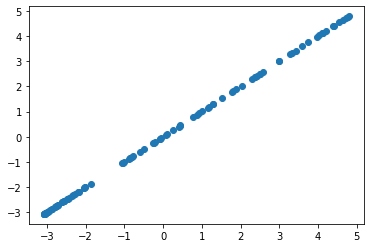

In [21]:
from matplotlib import pyplot as plt
plt.scatter(u - u.mean(), u_hat - u_hat.mean())

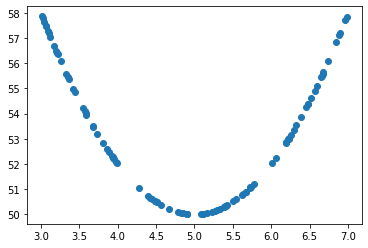

In [22]:
from matplotlib import pyplot as plt
u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])
plt.scatter(traj[:, -1, 0], u_hat)

In [34]:
ff_params["bond"]["coefficients"] = jnp.zeros_like(ff_params["bond"]["coefficients"])

In [26]:
ff_params["bond"]["coefficients"]

DeviceArray([[3.8633392e-05, 3.8633392e-05]], dtype=float32)